# Setup

In [1]:
import os, h5py
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from scipy.sparse import csc_matrix
import scipy
import scipy.signal
from scipy import sparse
from scipy.stats import norm
import re
import math

In [2]:
input_folder = r'\\filenest.diskstation.me\Wilbrecht_file_server\Madeline\processed_data'
input_file = r'JUV011\211215\JUV011-211215-gonogo-001.hdf5'

In [3]:
hfile = os.path.join(input_folder, input_file)
hf = h5py.File(hfile, 'r')
hf.keys()

<KeysViewHDF5 ['dff', 'dims', 'dview', 'estimates', 'mmap_file', 'params', 'remove_very_bad_comps', 'skip_refinement', 'snr']>

# Spatial Components ('A' matrix)

In [4]:
# A is stored as a scipy.sparse.csc_matrix
def load_A(hf):
    if 'estimates' in hf:
        A = hf['estimates']['A']
    else:
        A = hf['Nsparse']
    data = A['data']
    indices = A['indices']
    indptr = A['indptr']
    return csc_matrix((data, indices, indptr), A['shape'])


A = load_A(hf)
A.shape

(44944, 161)

In [5]:
dims = np.array(hf['dims'])
dims.tolist()

[212, 212]

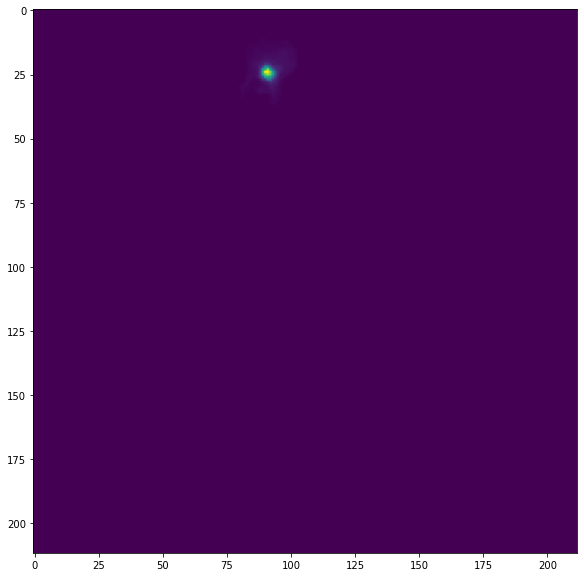

In [6]:
roi_index = 157
plt.figure(figsize=(10, 10))
plt.imshow(A.toarray()[:, roi_index].reshape(dims, order='F'))

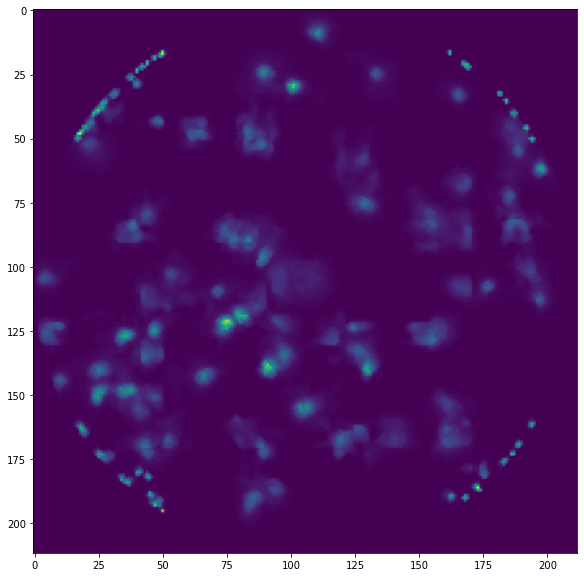

In [7]:
roi_aggregate = np.sum(A, axis=1)
plt.figure(figsize=(10, 10))
plt.imshow(roi_aggregate.reshape(dims, order='F'))

### Filter ROIs using SNR

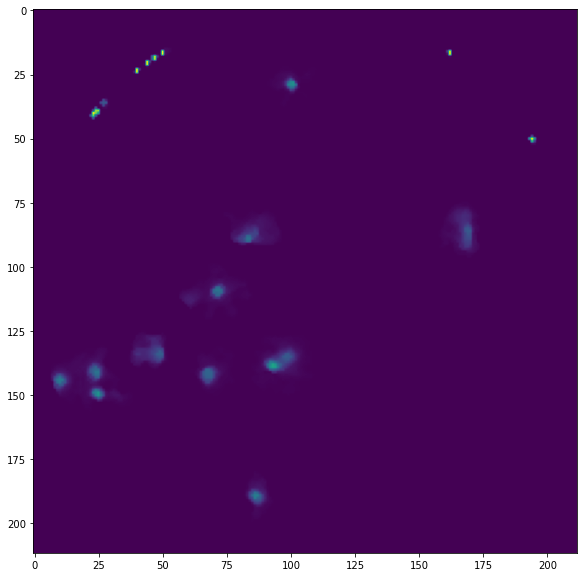

In [8]:
# will only add ROI's with SNR greater than this value
snr_cutoff = 7
n_rois = A.shape[1]
roi_filter_aggregate = np.zeros(shape=(A.shape[0], 1))
np.array(hf['snr'])
total = 0
for i in range(n_rois):
    if hf['snr'][i] > snr_cutoff:
        roi_filter_aggregate += A[:, i]
        total += 1
plt.figure(figsize=(10, 10))
plt.imshow(roi_filter_aggregate.reshape(dims, order='F'))

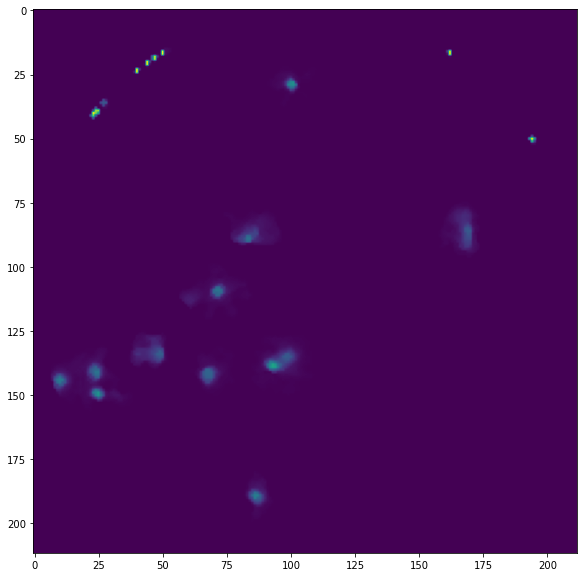

In [9]:
roi_fast = A[:, np.array(hf['snr']) > snr_cutoff].sum(axis=1)
plt.figure(figsize=(10, 10))
plt.imshow(roi_fast.reshape(dims, order='F'))

# Temporal Components ('C' Matrix)

In [10]:
C = np.array(hf['estimates/C'])
C.shape

(161, 36000)

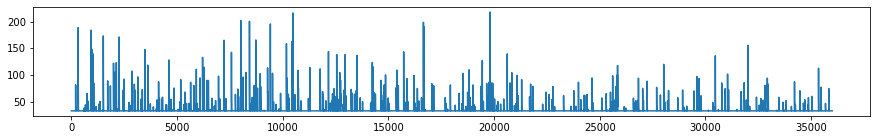

In [11]:
roi_index = 157
plt.figure(figsize=(15, 2))
plt.plot(C[roi_index])

### Find 'n' most active ROI's

In [12]:
n = 5
np.argpartition(np.std(C, axis=1), -n)[-n:].tolist()

[154, 100, 56, 99, 102]

# CaImAn Parameter Comparison

In [13]:
param_names = ['K', 'rf', 'stride_cnmf', 'gnb']
def get_param_string(params):
    return ', '.join([a + " = " + str(b) for a, b in zip(param_names, params)])

def roi_output(hfile):
    dims = np.array(hf['dims'])
    A = load_A(hfile)
    roi_aggregate = np.sum(A, axis=1)
    return roi_aggregate.reshape(dims, order='F')

In [14]:
input_folder = r'C:\Users\right\Documents\_CODE\lab\hard drive\madeline_data_output_4'
file_names = list(filter(lambda f: f.endswith('.hdf5'), os.listdir(input_folder)))
hfiles     = [h5py.File(os.path.join(input_folder, file), 'r') for file in file_names]

In [15]:
p = re.compile(r'^(.*)-(.*)-gonogo-001_(\d*)-(\d*)-(\d*).hdf5')

In [16]:
cols = 3
rows = math.ceil(len(file_names) / cols)

## Spatial Comparison

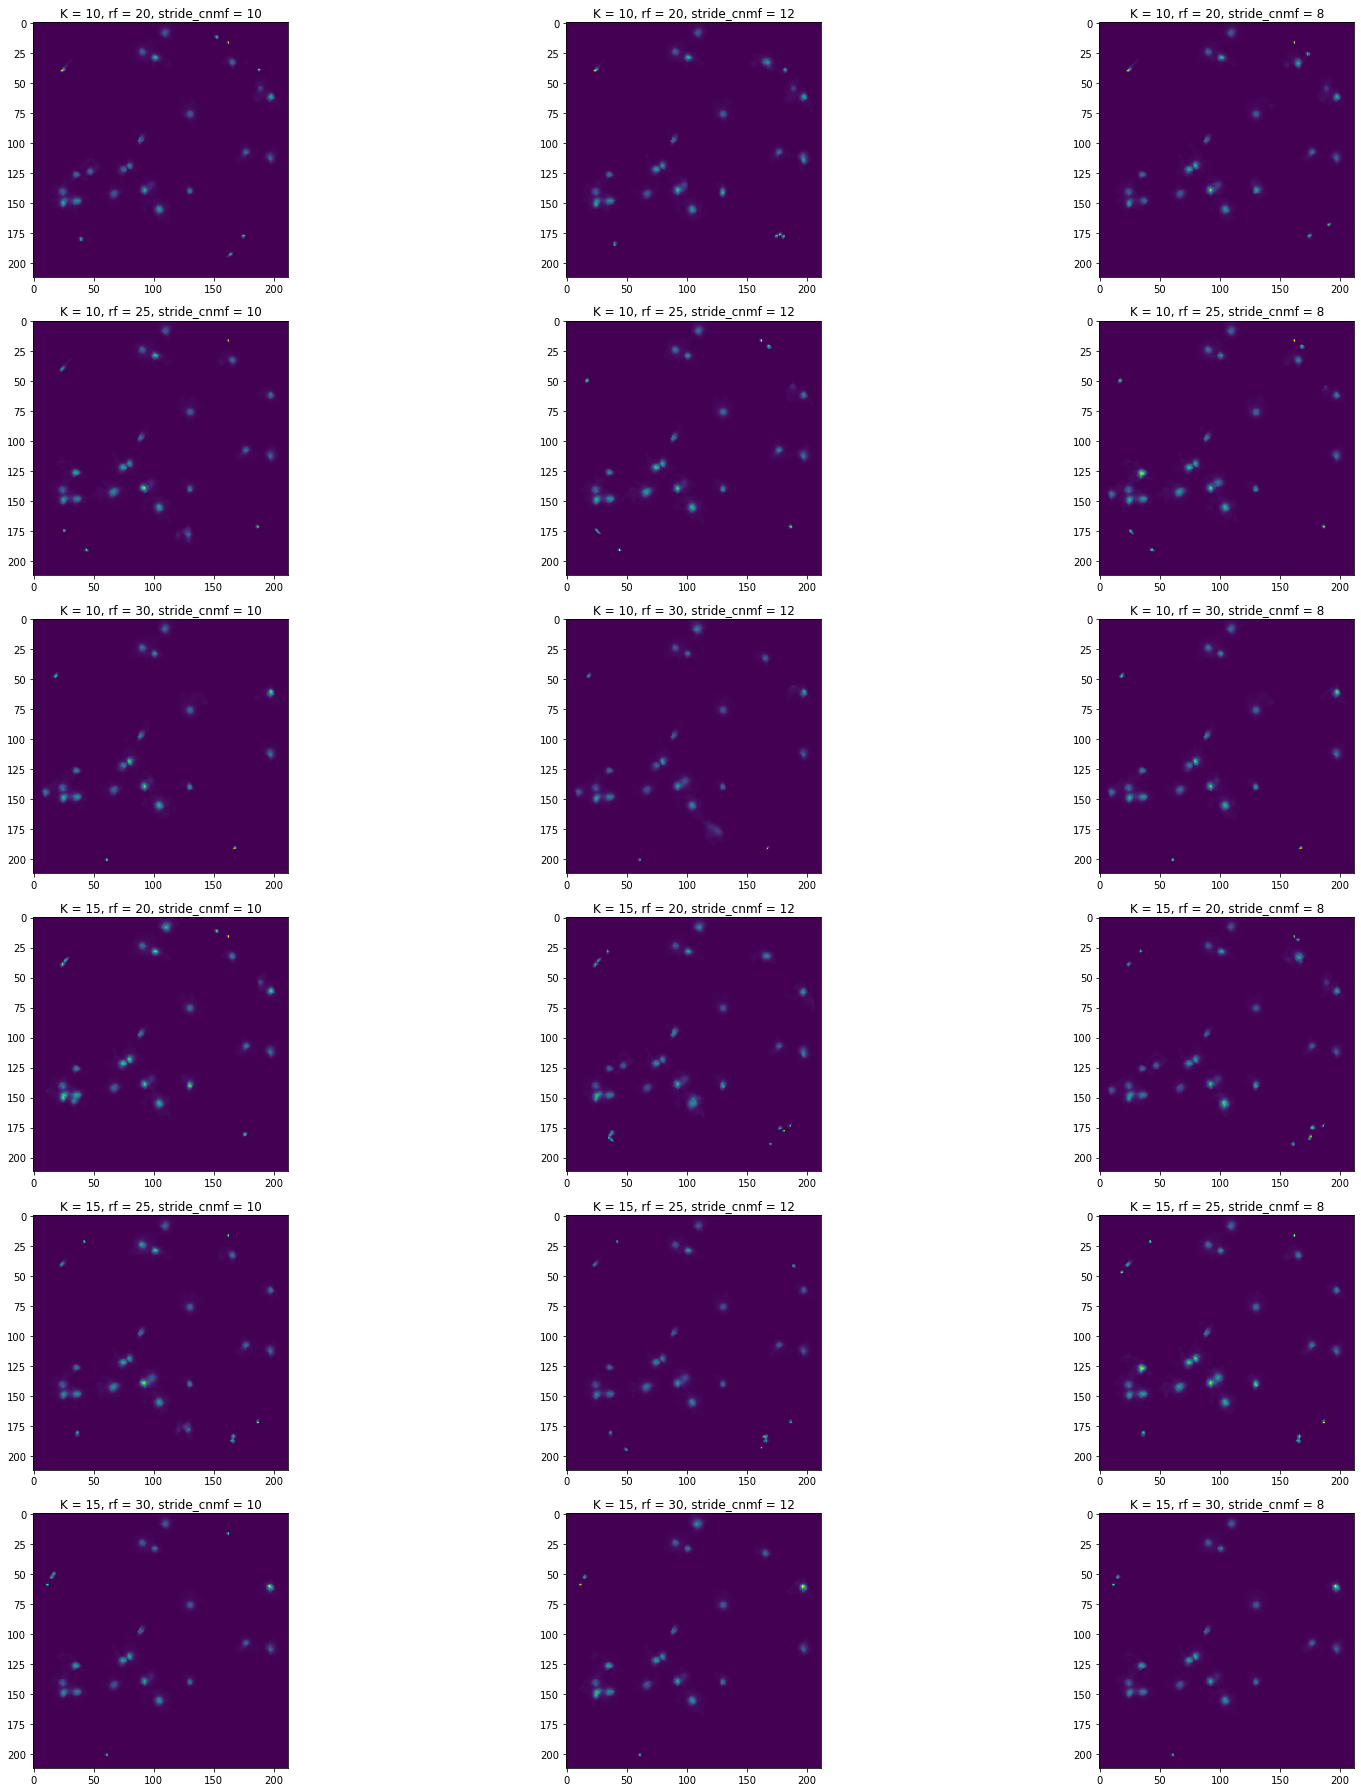

In [29]:
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(25,25))
for i, (file_name, hfile) in enumerate(zip(file_names, hfiles)):
    row, col = i // cols, i % cols
    axes[row][col].set_title(get_param_string(p.match(file_name).groups()[2:]))
    axes[row][col].imshow(roi_output(hfile))
for unused_index in range(len(file_names), rows * cols):
    row, col = unused_index // cols, unused_index % cols
    axes[row, col].axis('off')
fig.tight_layout()

## Temporal Comparison

In [18]:
def get_roi_indices(C):
    sorted_indices = np.argsort(np.std(C, axis=1))
    return sorted_indices[-1], sorted_indices[len(C)//2], sorted_indices[0]

def plot_C_index(roi_number, title, num_frames):
    plt.figure(figsize=(15, 2))
    plt.title(title)
    plt.plot(C[roi_number][:num_frames])

def plot_dff_index(roi_number, title, num_frames):
    plt.figure(figsize=(15, 2))
    plt.title(title)
    plt.plot(dff[roi_number][:num_frames])

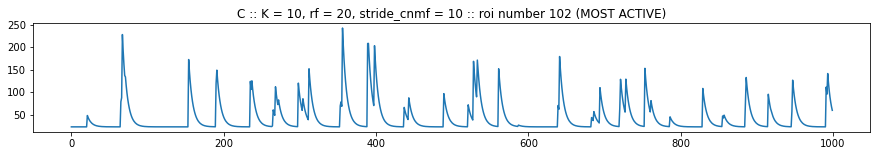

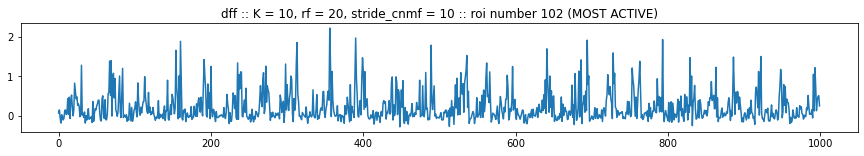

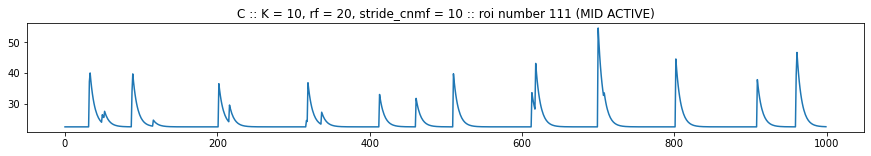

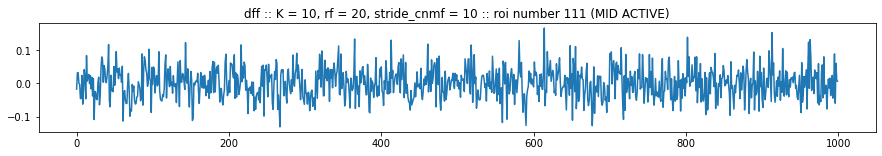

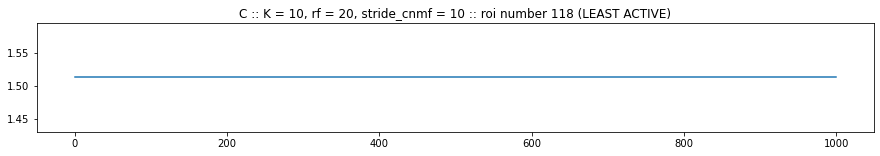

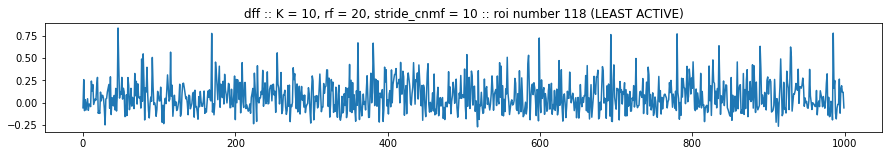

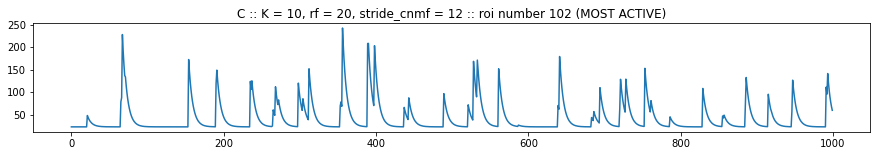

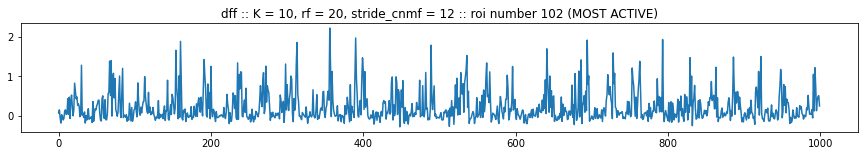

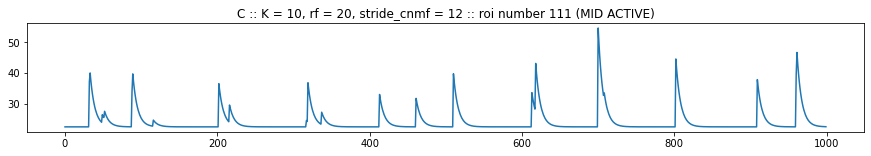

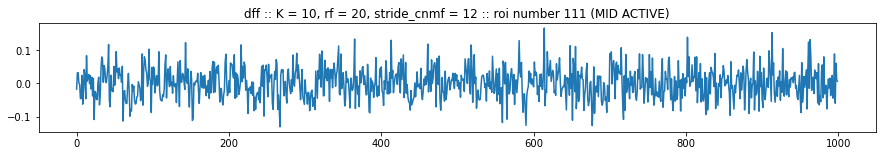

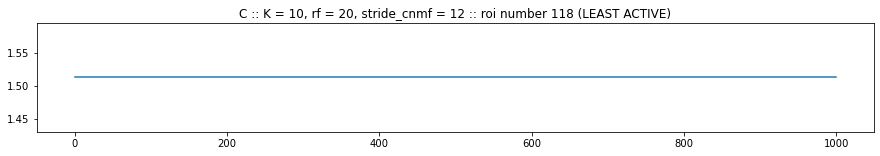

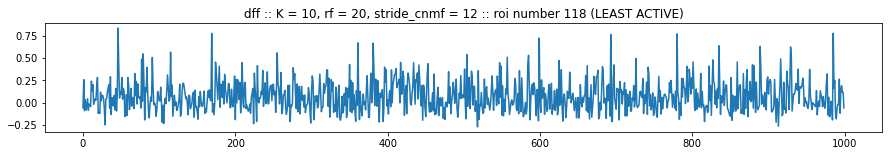

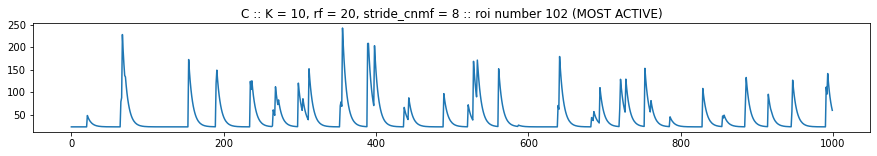

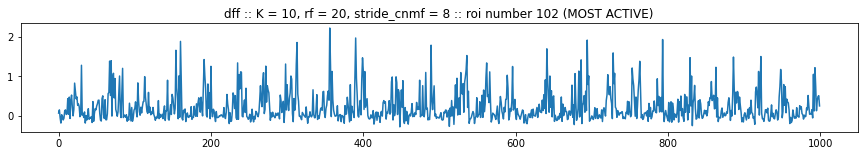

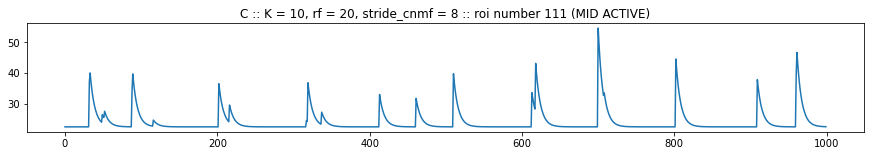

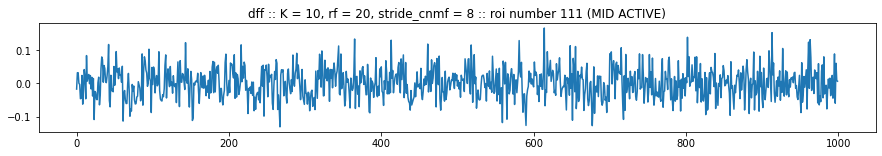

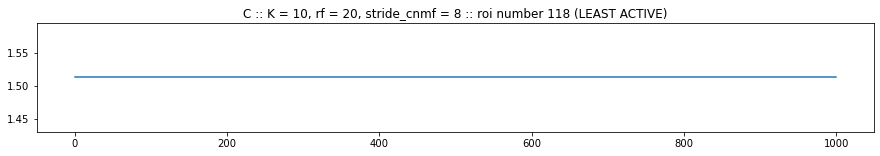

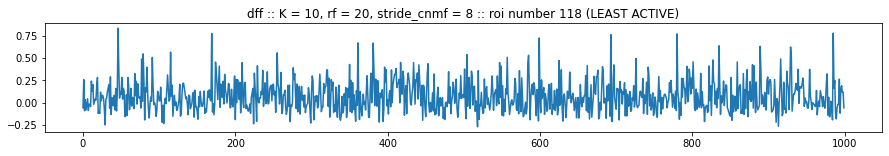

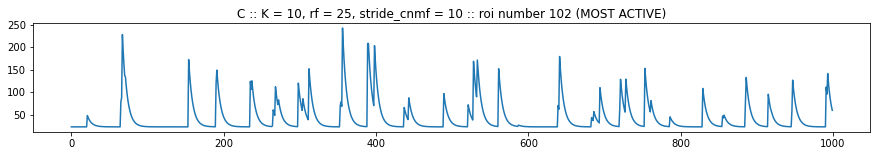

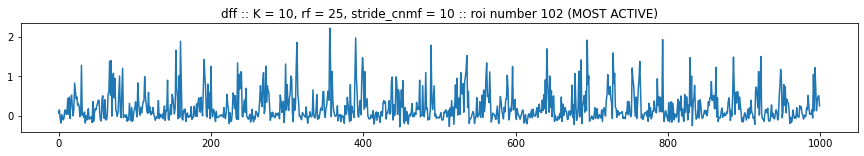

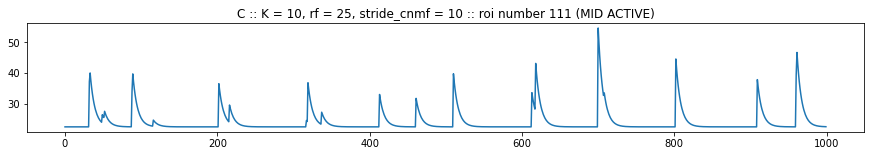

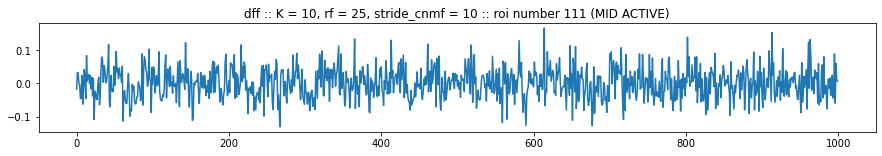

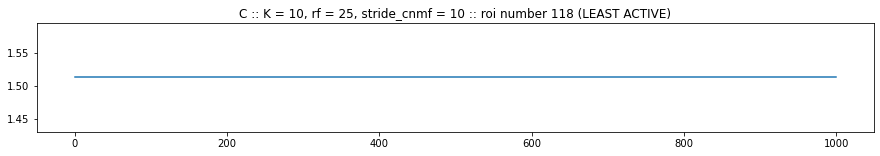

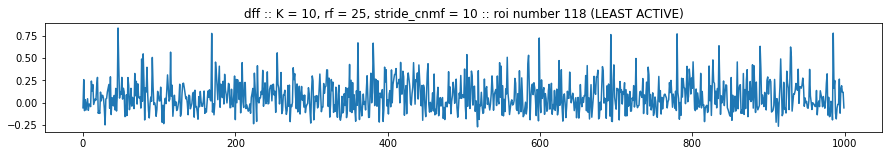

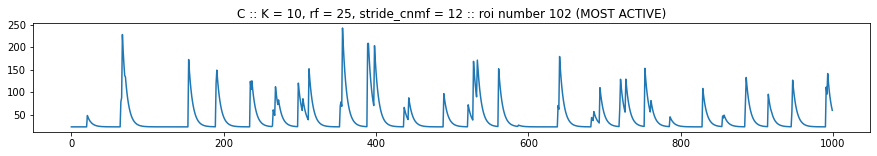

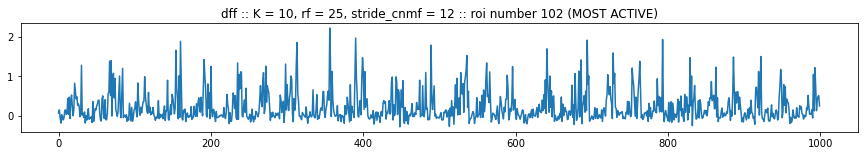

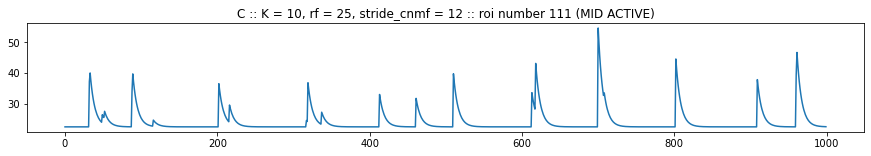

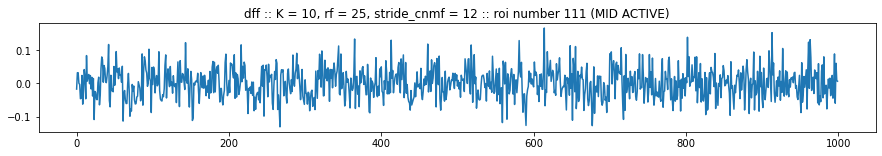

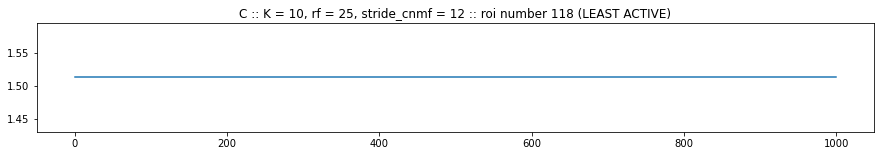

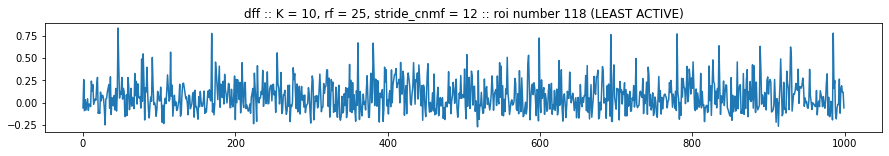

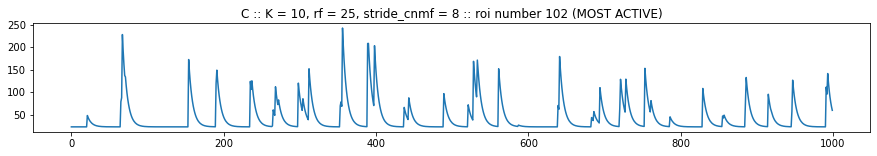

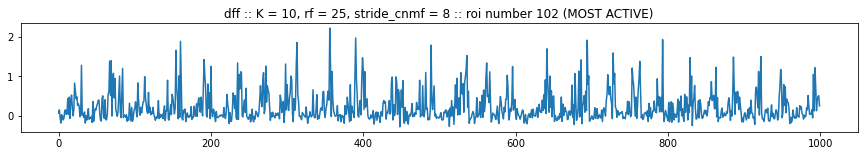

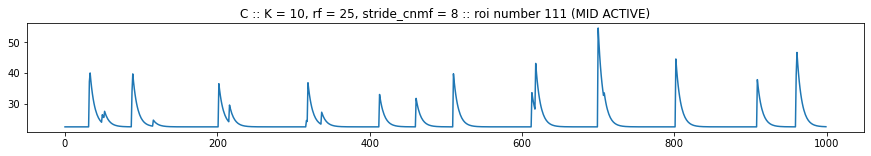

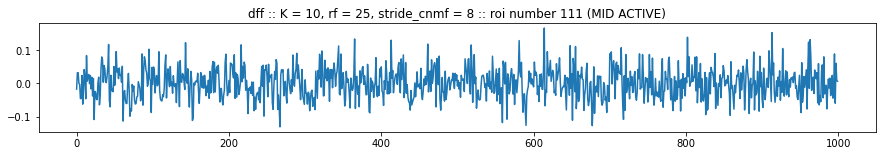

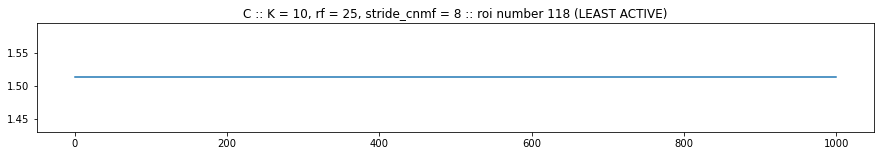

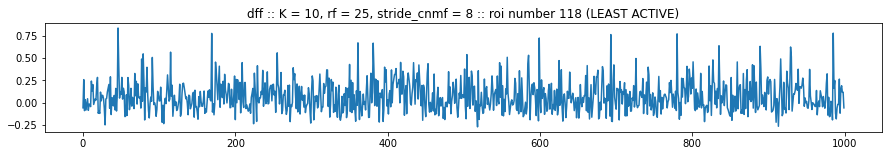

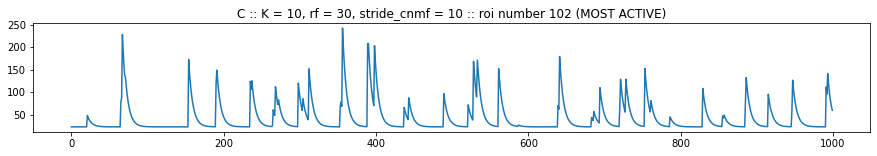

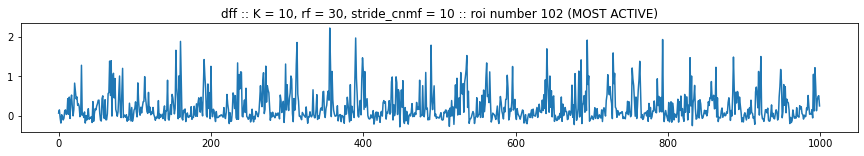

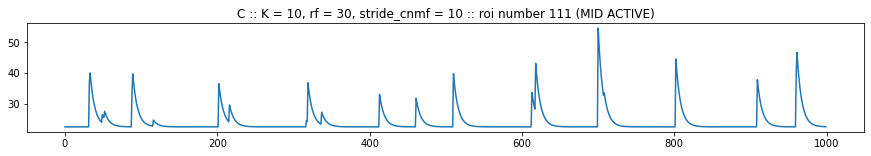

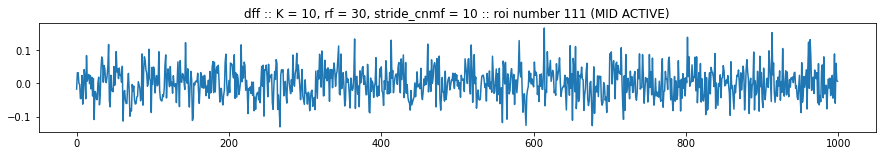

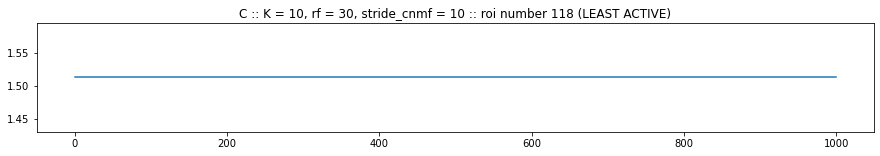

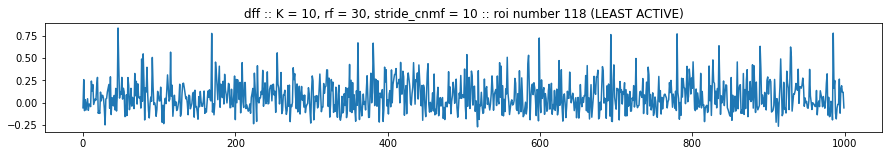

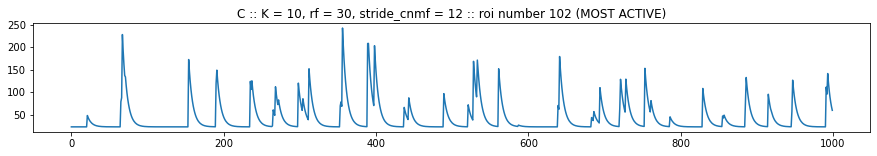

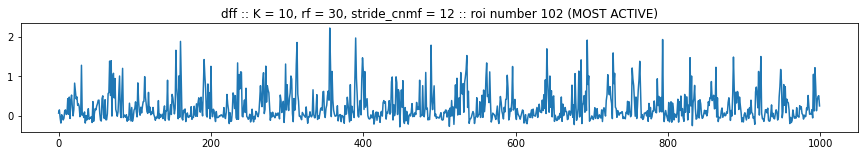

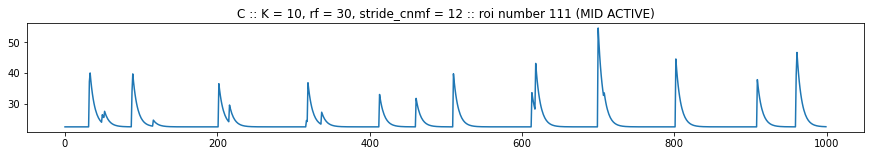

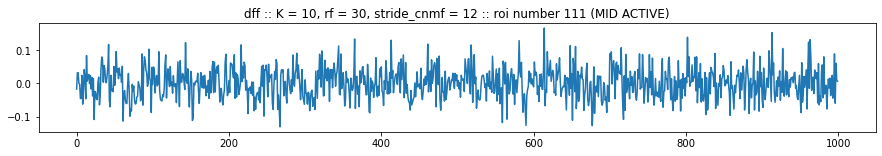

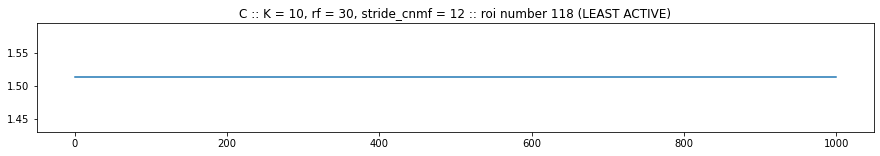

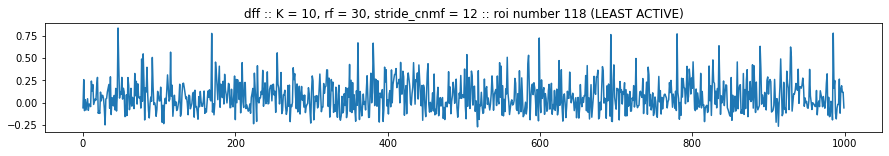

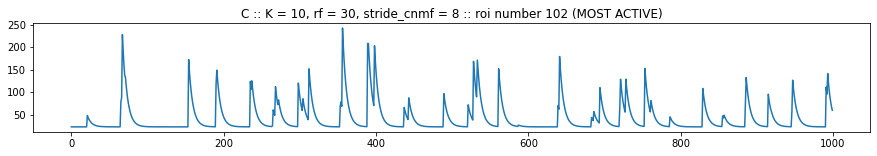

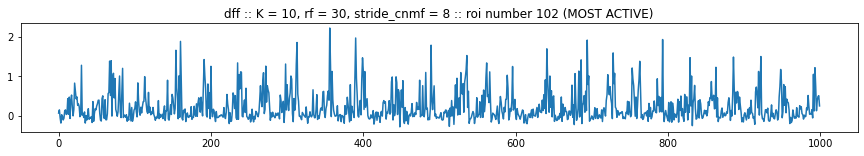

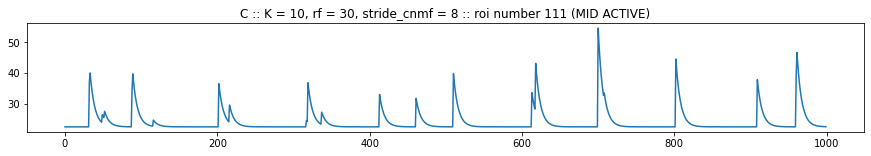

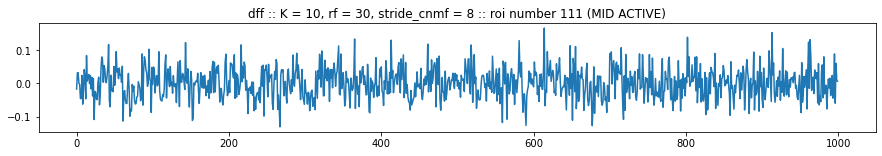

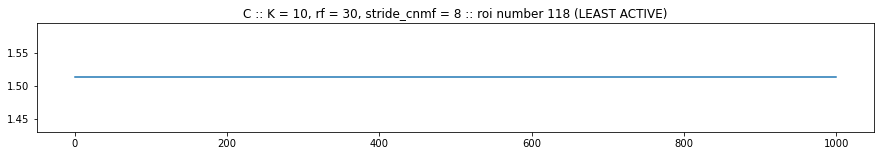

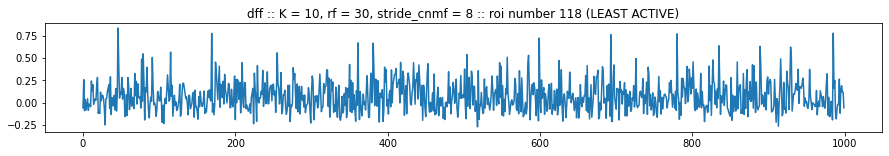

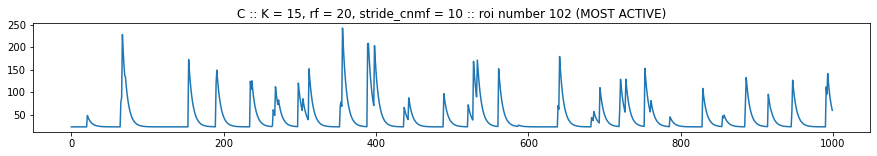

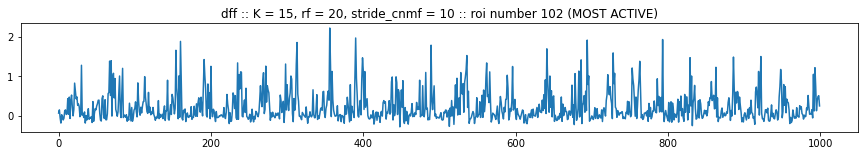

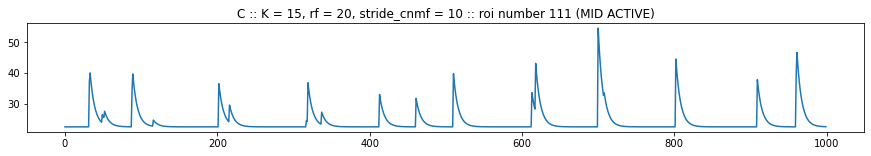

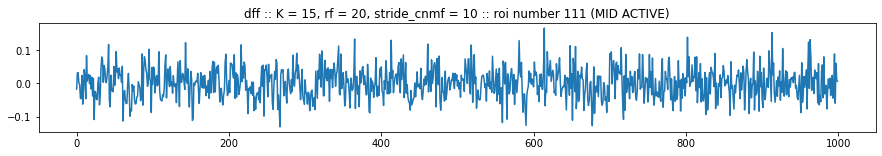

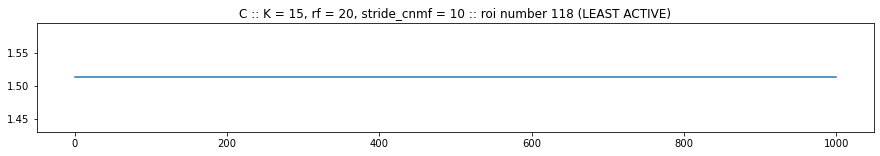

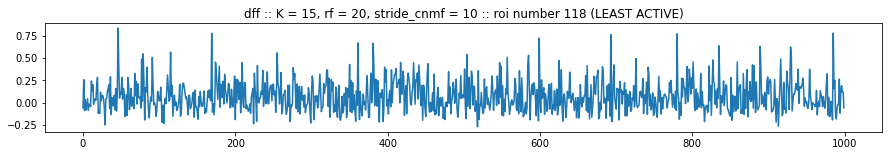

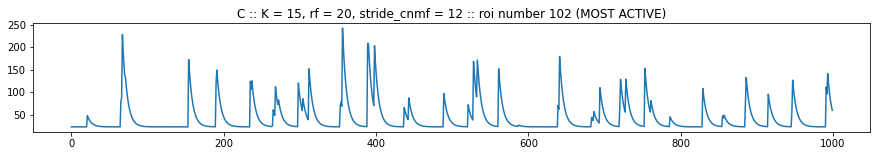

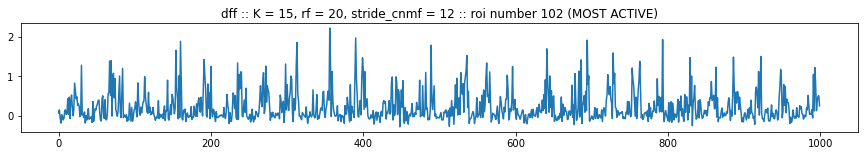

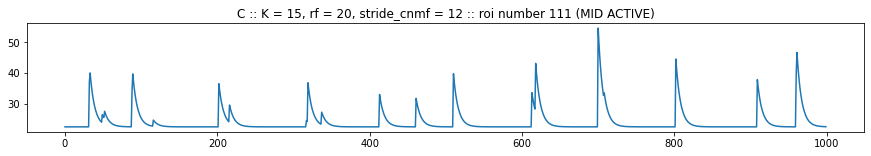

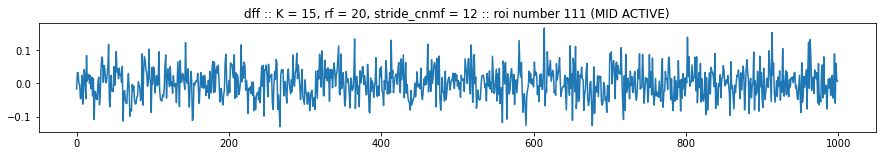

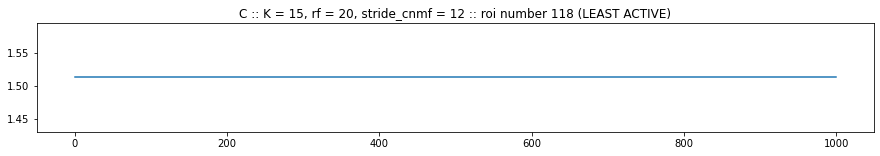

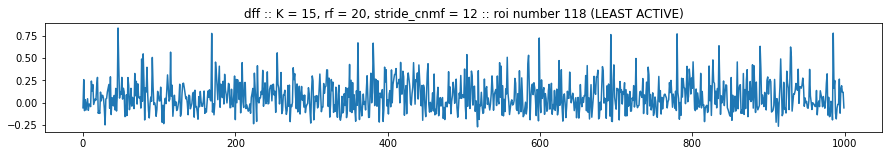

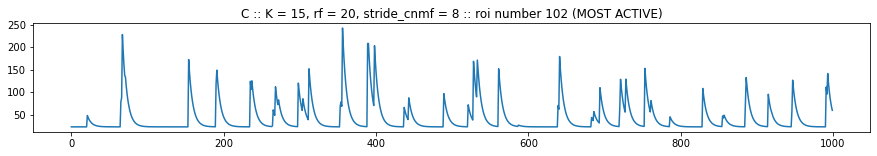

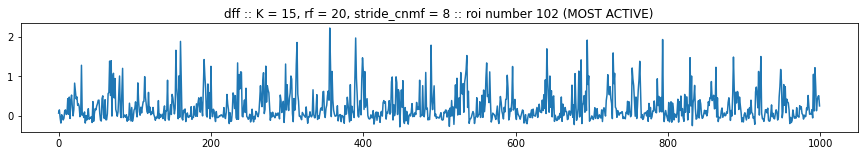

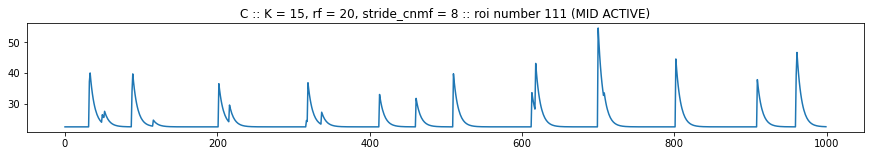

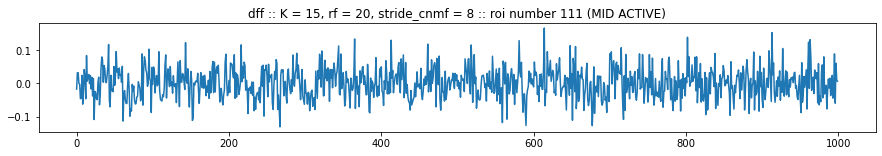

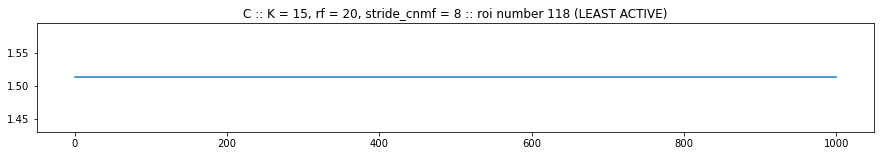

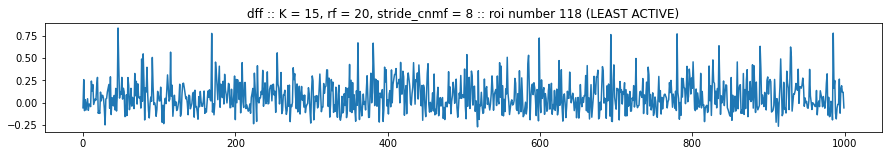

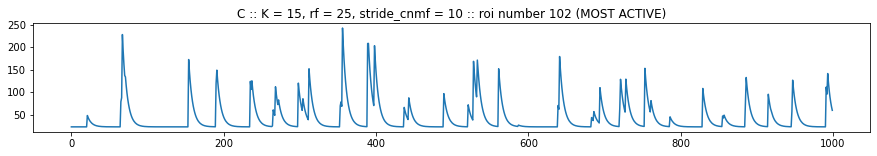

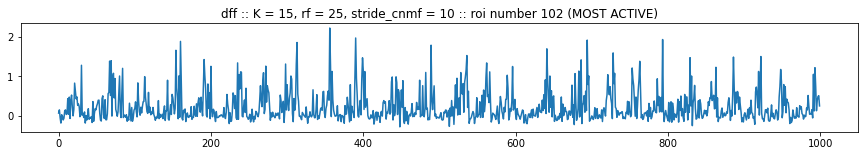

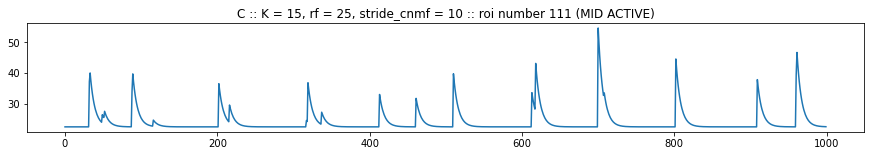

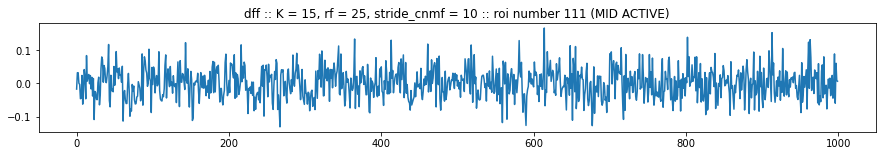

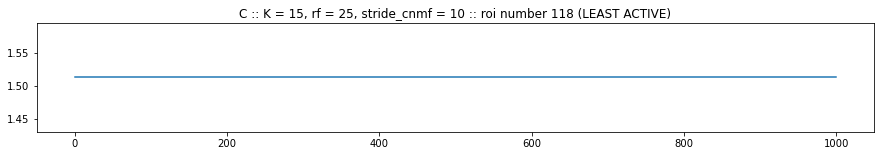

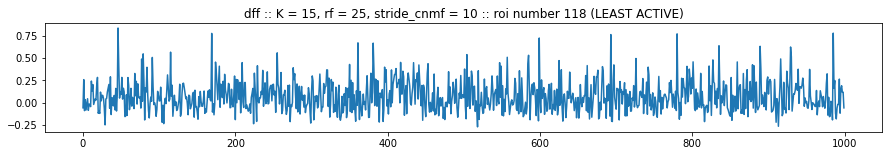

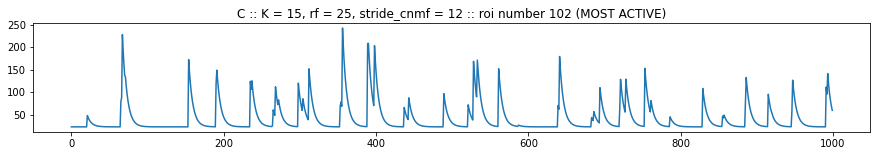

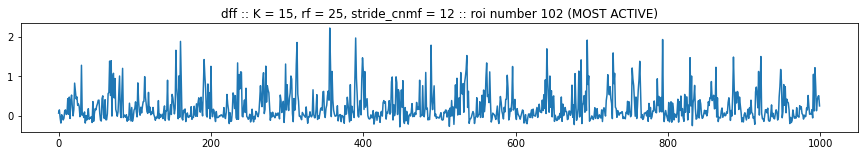

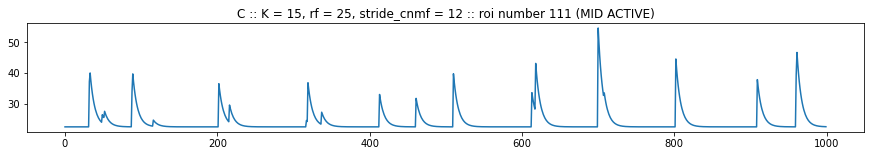

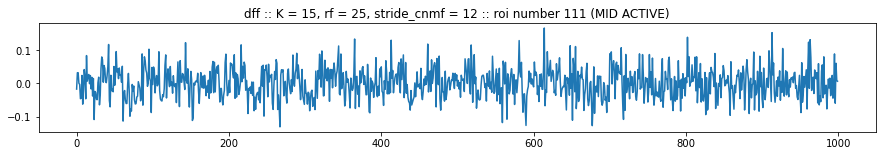

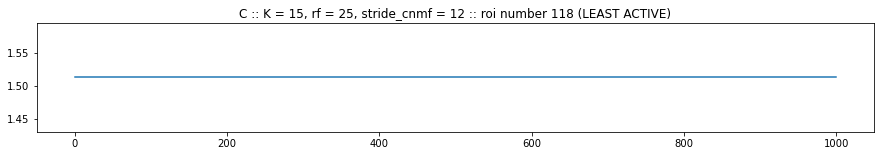

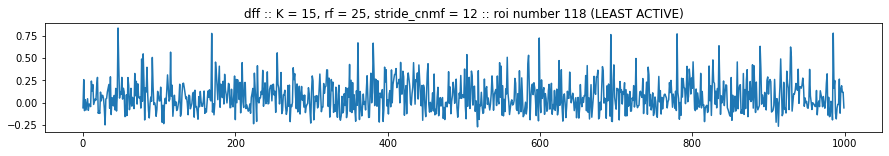

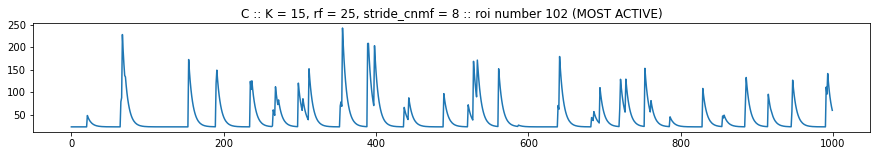

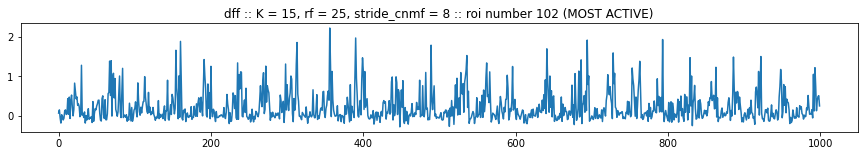

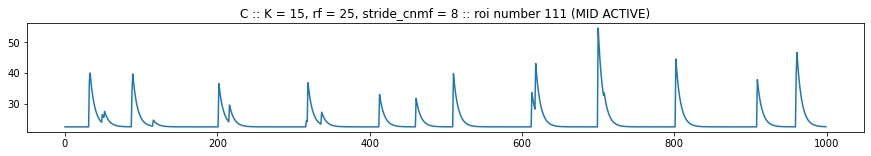

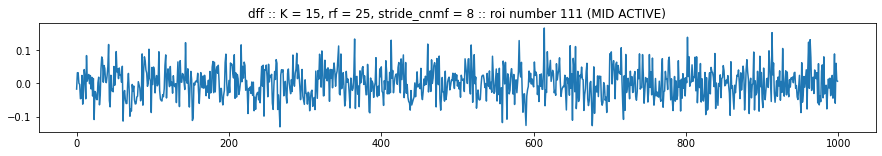

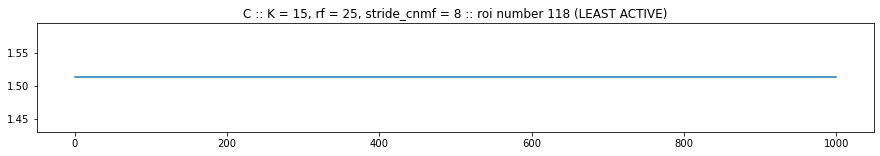

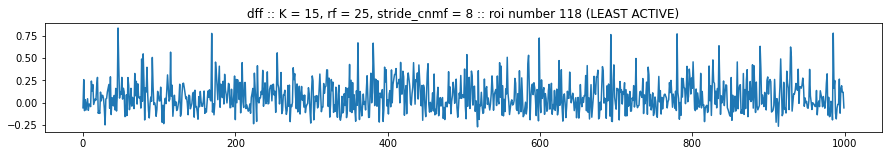

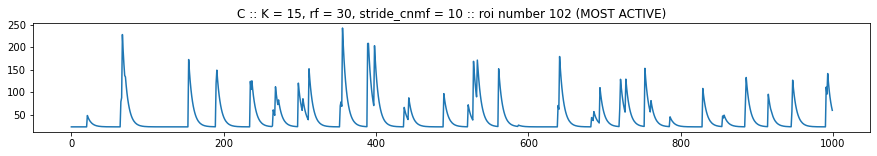

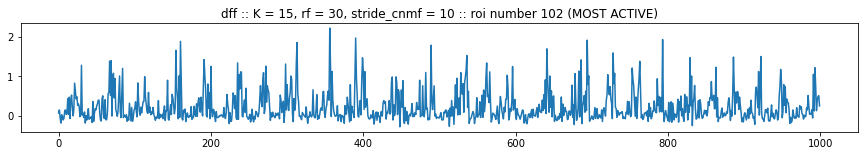

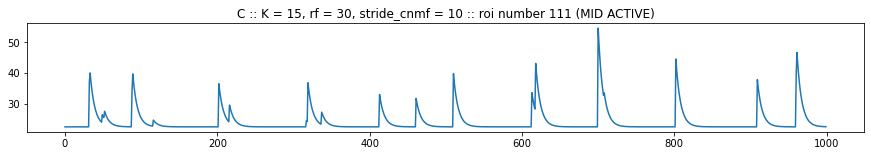

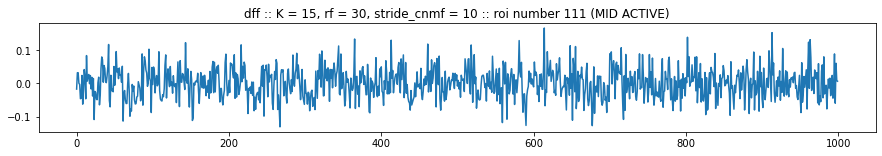

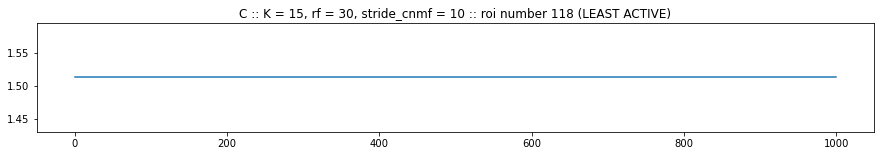

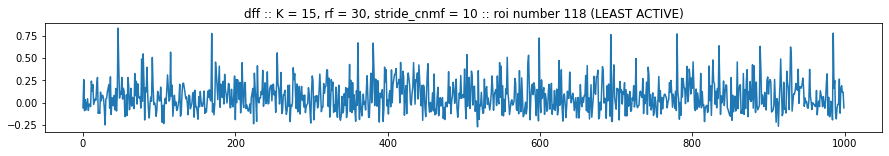

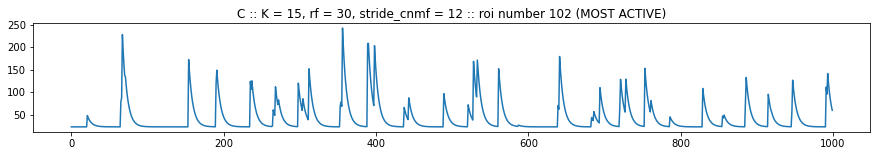

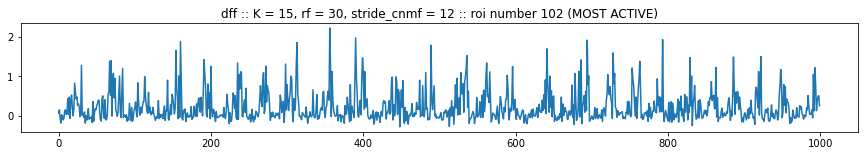

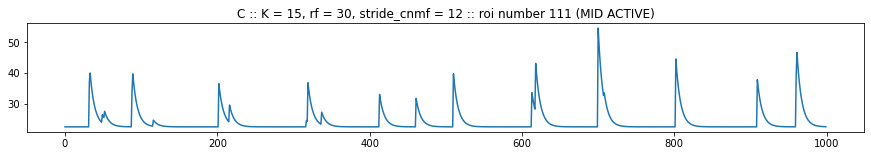

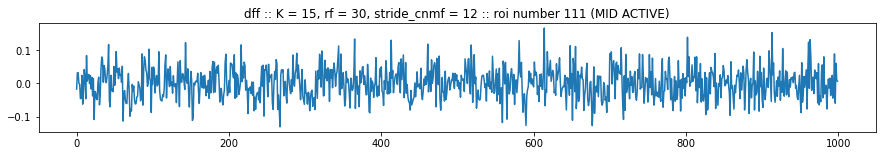

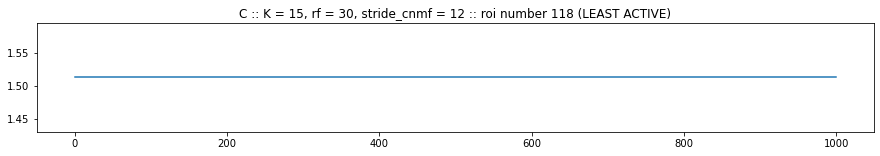

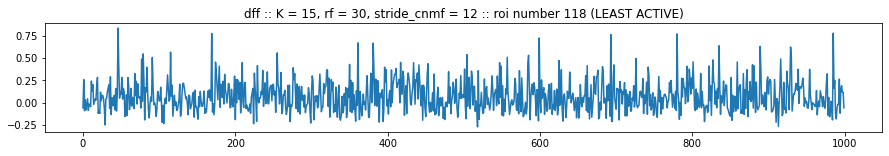

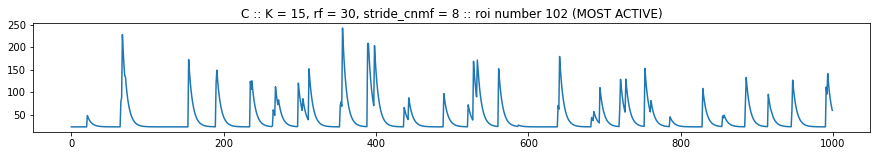

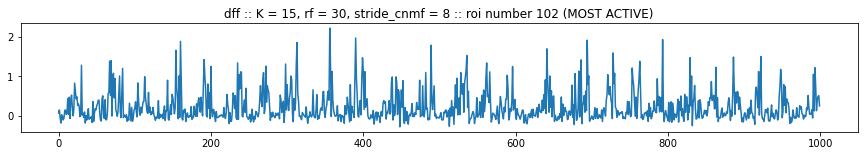

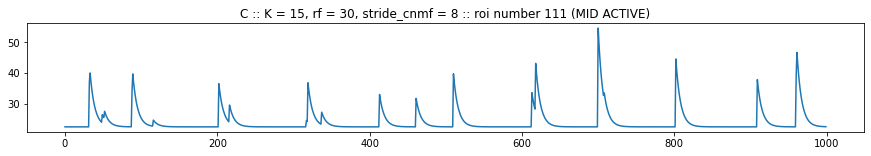

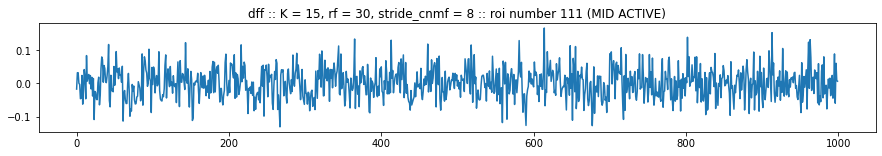

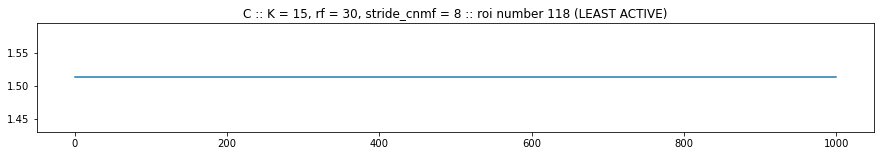

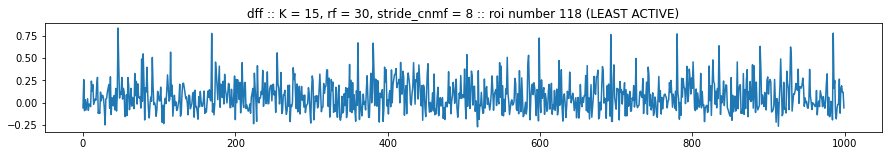

In [19]:
num_frames = 1000
# Plot the C and dff of the most active, least active, and median ROI for each hfile
for i in range(len(file_names)):
    file_name = file_names[i]
    hfile = hfiles[i]
    # get C and dff
    C = np.array(hf['estimates/C'])
    dff = np.array(hf['dff'])
    # get ROI indices
    top_roi, mid_roi, low_roi = get_roi_indices(C)
    # plot C and dff for each index
    param_string = get_param_string(p.match(file_name).groups()[2:])
    C_plot_title   =   'C :: ' + param_string + ' :: roi number '
    dff_plot_title = 'dff :: ' + param_string + ' :: roi number '
    plot_C_index(top_roi, C_plot_title + str(top_roi) + ' (MOST ACTIVE)', num_frames)
    plot_dff_index(top_roi, dff_plot_title + str(top_roi) + ' (MOST ACTIVE)', num_frames)
    plot_C_index(mid_roi, C_plot_title + str(mid_roi) + ' (MID ACTIVE)', num_frames)
    plot_dff_index(mid_roi, dff_plot_title + str(mid_roi) + ' (MID ACTIVE)', num_frames)
    plot_C_index(low_roi, C_plot_title + str(low_roi) + ' (LEAST ACTIVE)', num_frames)
    plot_dff_index(low_roi, dff_plot_title + str(low_roi) + ' (LEAST ACTIVE)', num_frames)

In [20]:
def compare_matching_neurons(A1, A2):
    return scipy.signal.correlate(A1, A2)

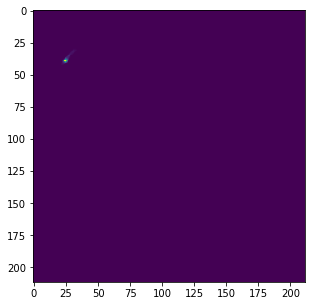

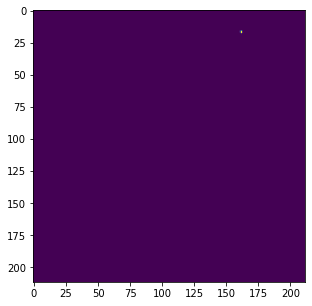

In [21]:
A1 = load_A(hfiles[0]).toarray()
A2 = load_A(hfiles[5]).toarray()
plt.figure(figsize=(5, 5))
plt.imshow(A1[:, 0].reshape(dims, order='F'))
plt.figure(figsize=(5, 5))
plt.imshow(A2[:, 4].reshape(dims, order='F'))

In [22]:
for j in range(len(A2[0])):
    print(j, ":", np.corrcoef(A1[:, 0], A2[:, j])[0][1])
    
# coeffs = [np.corrcoef(A1[:, 0], A2[:, j])[0][1] for j in range(len(A2[0]))]
# print(max(coeffs))

0 : -0.0002457569635760974
1 : -0.0005313664586037733
2 : -0.0007290615701260855
3 : -0.0006566320557520258
4 : -0.0001323013098704675
5 : -0.0002445884251485843
6 : -0.0006430115583961181
7 : -0.0004109139533631772
8 : -0.0005580772238611965
9 : -0.0004837610772244646
10 : -0.00048695797567913123
11 : -0.0006993149900647393
12 : -0.0006868537651651424
13 : -0.0006543624396712683
14 : -0.0005499314928574526
15 : -0.0008491835329847892
16 : -0.0005083562911674822
17 : -0.0005867071442535855
18 : -0.0004234737029378675
19 : -0.0007372265598891164
20 : -0.0006396047453141364
21 : -0.0007880655829411516
22 : -0.0006555116258925227
23 : -0.0007141882862882614
24 : -0.00022457556900681123
25 : -0.00020480379161992728
26 : -0.0001957200613385229
27 : -0.0004599534683578157
28 : -0.0008062430679982981
29 : -0.0008242752515561211
30 : -0.0005097039404712414
31 : -0.00043943010867474643
32 : -0.0006139210205087579


In [23]:
for i in range(1):
    for j in range(len(A2[0]) // 2):
        plt.figure(figsize=(5, 5))
        out = scipy.signal.correlate(A1[:, i], A2[:, j])
        print(np.corrcoef(A1[:, i], A2[:, j]))

[[ 1.00000000e+00 -2.45756964e-04]
 [-2.45756964e-04  1.00000000e+00]]
[[ 1.00000000e+00 -5.31366459e-04]
 [-5.31366459e-04  1.00000000e+00]]
[[ 1.0000000e+00 -7.2906157e-04]
 [-7.2906157e-04  1.0000000e+00]]
[[ 1.00000000e+00 -6.56632056e-04]
 [-6.56632056e-04  1.00000000e+00]]
[[ 1.0000000e+00 -1.3230131e-04]
 [-1.3230131e-04  1.0000000e+00]]
[[ 1.00000000e+00 -2.44588425e-04]
 [-2.44588425e-04  1.00000000e+00]]
[[ 1.00000000e+00 -6.43011558e-04]
 [-6.43011558e-04  1.00000000e+00]]
[[ 1.00000000e+00 -4.10913953e-04]
 [-4.10913953e-04  1.00000000e+00]]
[[ 1.00000000e+00 -5.58077224e-04]
 [-5.58077224e-04  1.00000000e+00]]
[[ 1.00000000e+00 -4.83761077e-04]
 [-4.83761077e-04  1.00000000e+00]]
[[ 1.00000000e+00 -4.86957976e-04]
 [-4.86957976e-04  1.00000000e+00]]
[[ 1.0000000e+00 -6.9931499e-04]
 [-6.9931499e-04  1.0000000e+00]]
[[ 1.00000000e+00 -6.86853765e-04]
 [-6.86853765e-04  1.00000000e+00]]
[[ 1.0000000e+00 -6.5436244e-04]
 [-6.5436244e-04  1.0000000e+00]]
[[ 1.00000000e+00 -5.4

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

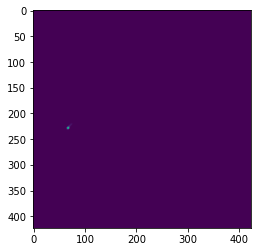

In [24]:
out = compare_matching_neurons(A1[:, 0].reshape(dims, order='F'), A2[:, 5].reshape(dims, order='F'))
plt.imshow(out)

In [25]:
a = A1[:, 0]
b = A2[:, 1]
np.correlate(a, b)

array([0.])

In [26]:
def sparse_corrcoef(A, B=None):

    if B is not None:
        A = sparse.vstack((A, B), format='csr')

    A = A.astype(np.float64)
    n = A.shape[1]

    # Compute the covariance matrix
    rowsum = A.sum(1)
    centering = rowsum.dot(rowsum.T.conjugate()) / n
    C = (A.dot(A.T.conjugate()) - centering) / (n - 1)

    # The correlation coefficients are given by
    # C_{i,j} / sqrt(C_{i} * C_{j})
    d = np.diag(C)
    coeffs = C / np.sqrt(np.outer(d, d))

    return coeffs

In [27]:
load_A(hfiles[0])

<44944x34 sparse matrix of type '<class 'numpy.float64'>'
	with 7185 stored elements in Compressed Sparse Column format>